In [10]:
import json
import glob
import numpy as np
from sprkana.utils import (
    load_yaml,
    create_dir
)
from typing import List
import matplotlib.pyplot as plt

Plotting histogram jet_pt_0 with dictionary {'name': 'jet_pt_0', 'nbins': 50, 'bounds': [0.0, 4000.0], 'col_name': 'jet_pt_0', 'xlabel': 'Leading jet $p_T$ (GeV)'}...
Making plot from directory '../outputs/2025-08-26_empflow/FCS_BinnedShower/HISTS' with label 'FCS, BinnedShower Photons' and color red
Making plot from directory '../outputs/2025-08-26_empflow/FCS_Standard/HISTS' with label 'FCS, Standard' and color blue
Making plot from directory '../outputs/2025-08-26_empflow/FS/HISTS' with label 'Geant4' and color green
Plotting histogram jet_eta_0 with dictionary {'name': 'jet_eta_0', 'nbins': 100, 'bounds': [-7.0, 7.0], 'col_name': 'jet_eta_0', 'xlabel': 'Leading jet $\\eta$'}...
Making plot from directory '../outputs/2025-08-26_empflow/FCS_BinnedShower/HISTS' with label 'FCS, BinnedShower Photons' and color red
Making plot from directory '../outputs/2025-08-26_empflow/FCS_Standard/HISTS' with label 'FCS, Standard' and color blue
Making plot from directory '../outputs/2025-08-26_empf

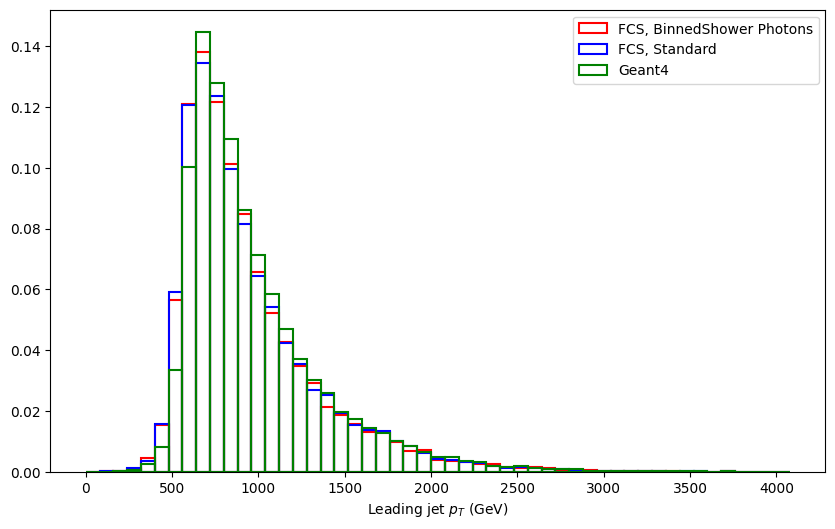

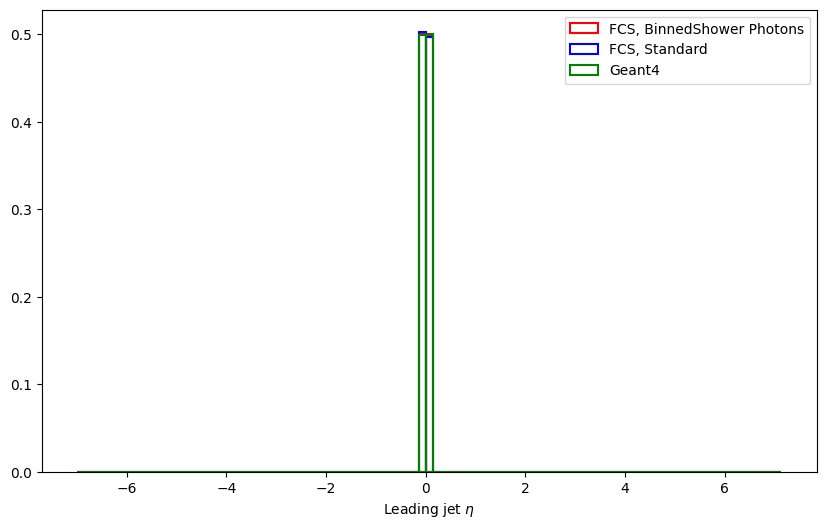

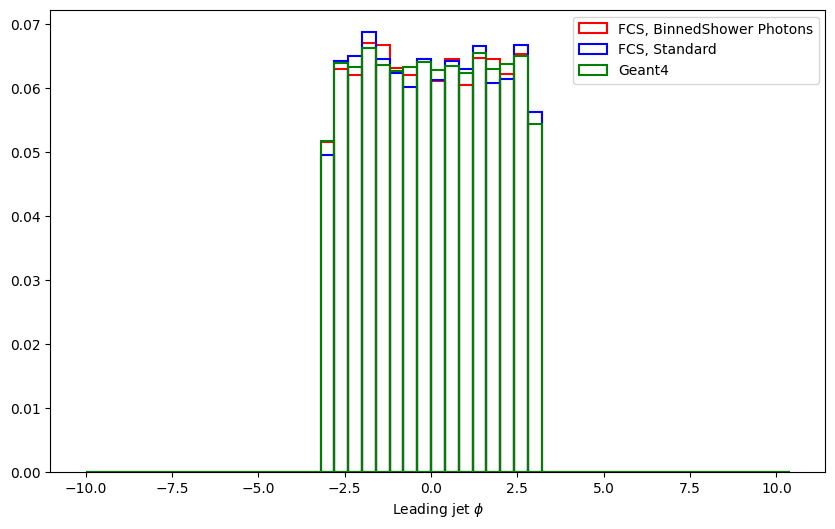

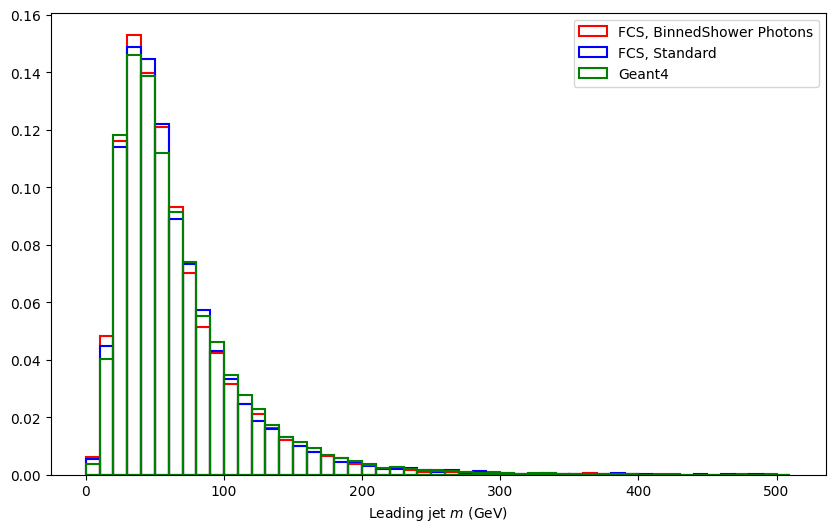

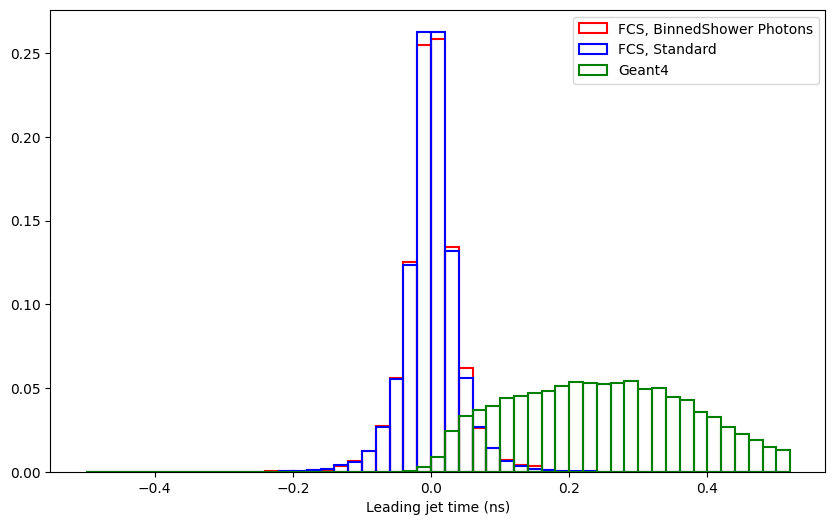

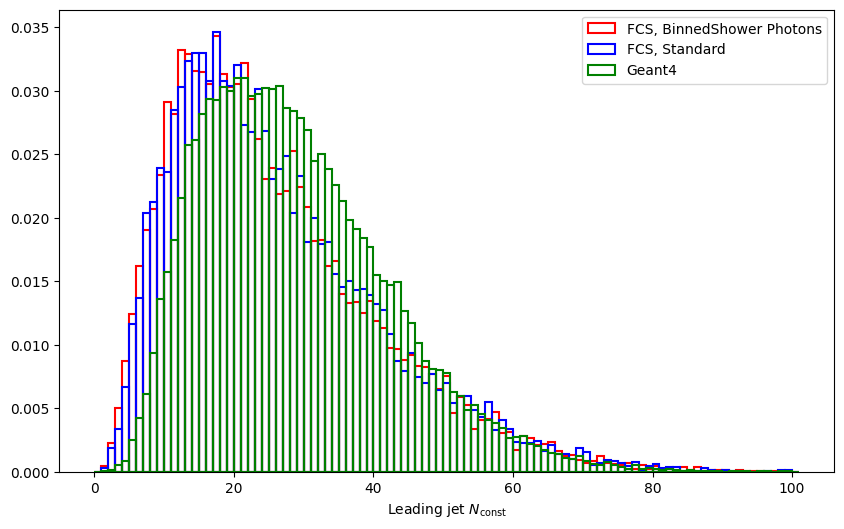

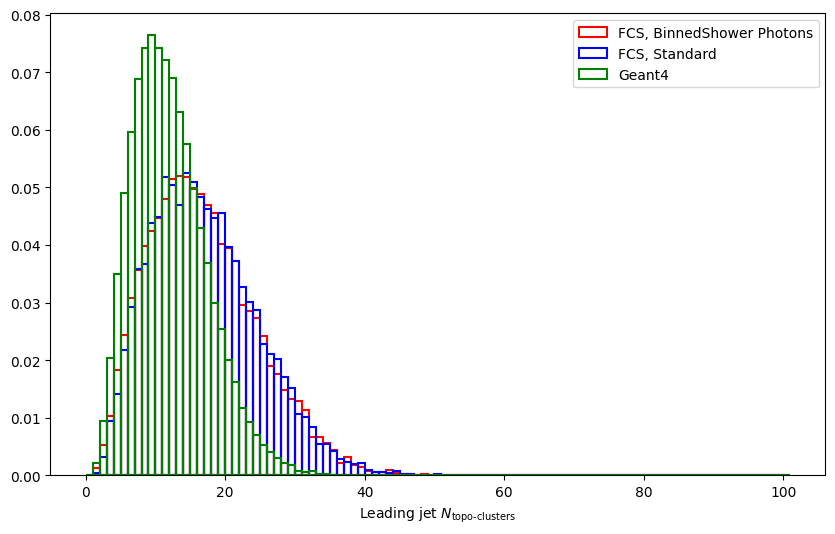

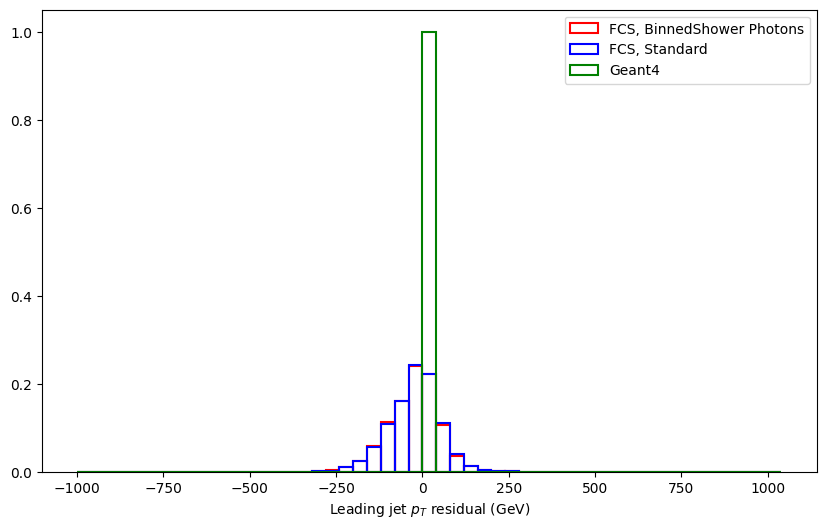

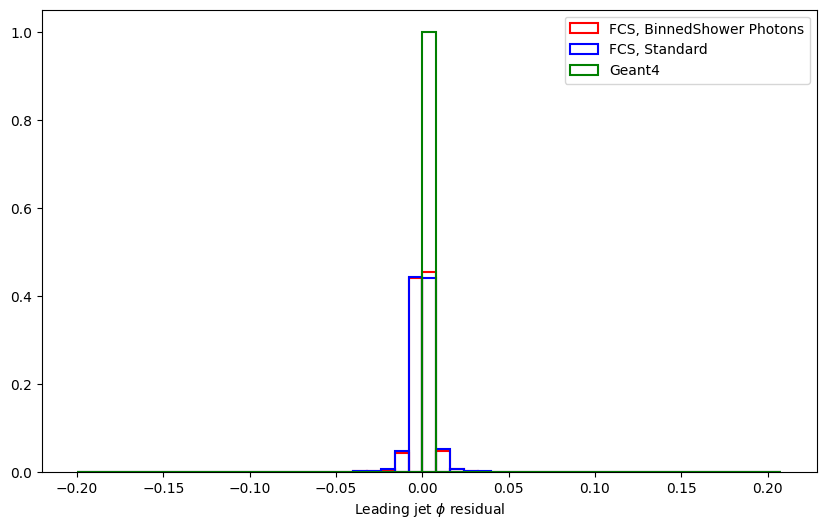

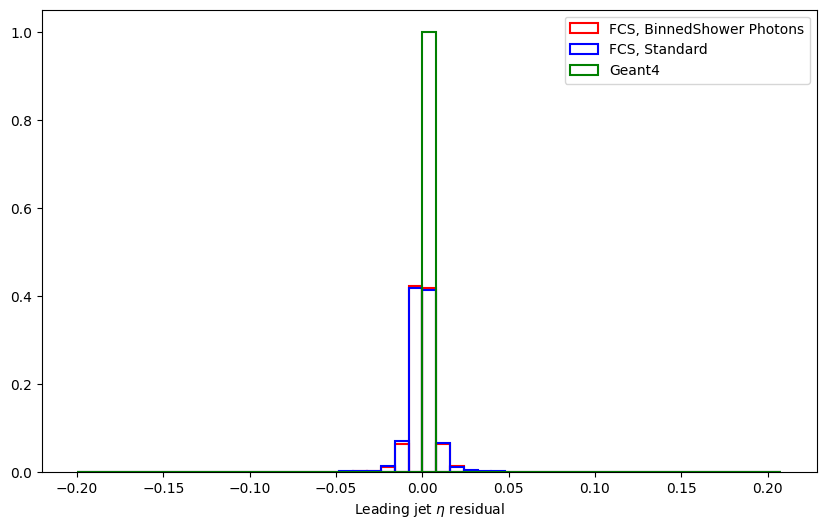

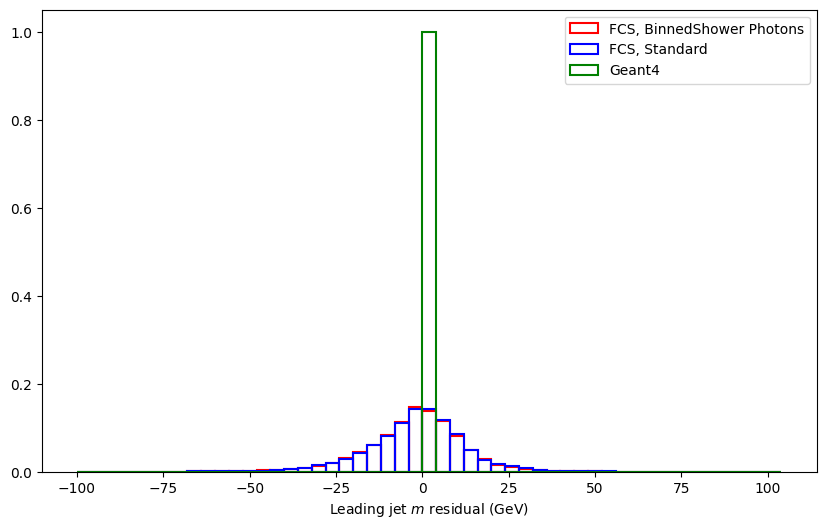

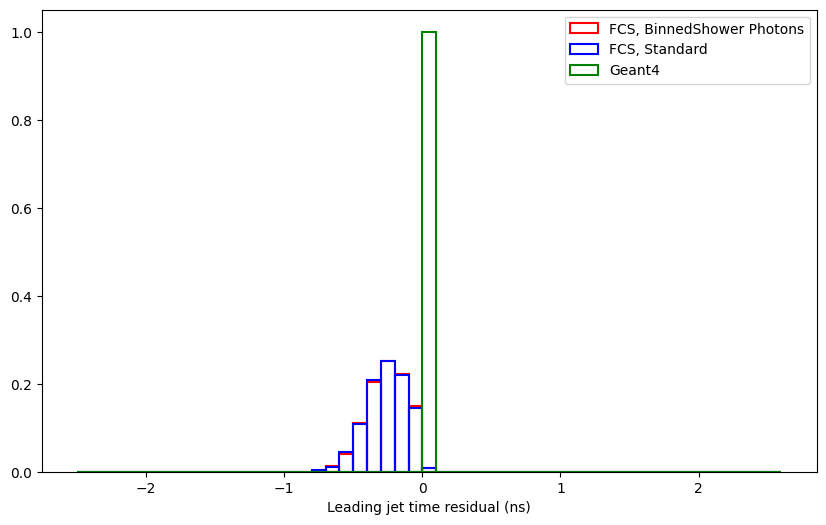

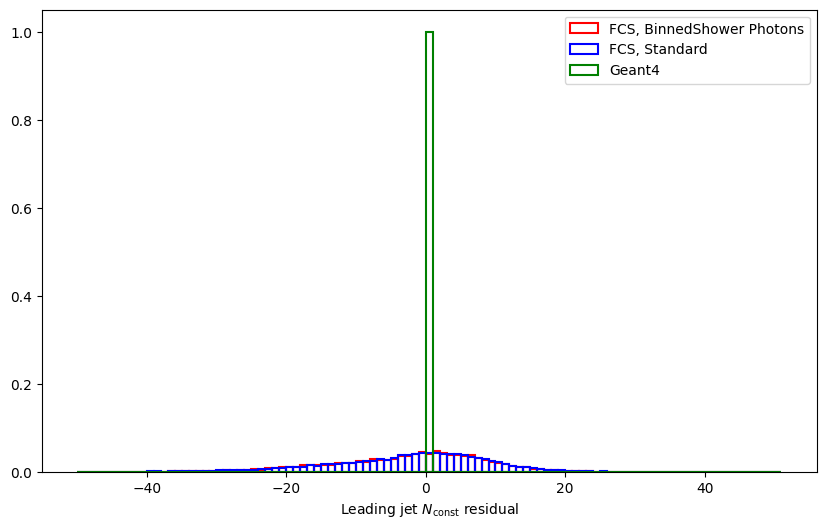

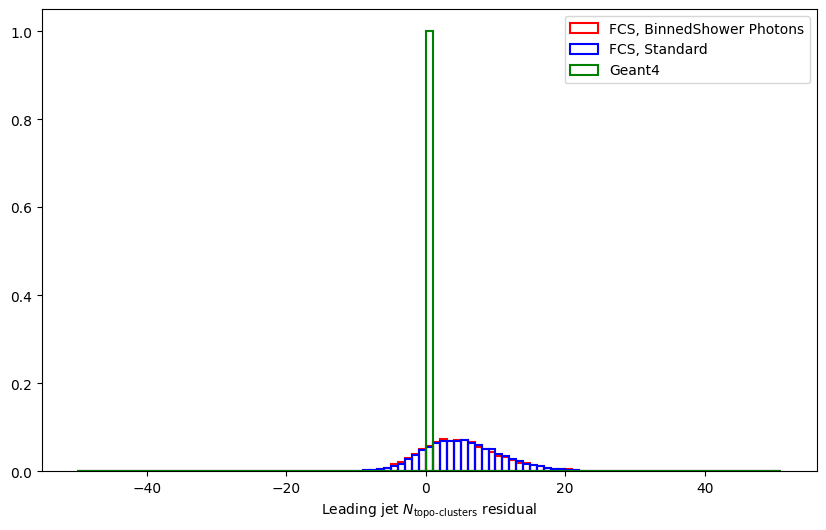

In [11]:

def load_json_file(fname:str):
    count = None
    bin_start = None
    bin_end = None
    with open(fname, "r") as f:
        for line in f:
            if not line.strip():
                continue  # skip empty lines
            data = json.loads(line)  # each line is a JSON object
            #Bin start
            if bin_start is None:
                bin_start = np.array(data["bin_start"], dtype=float)
            else:
                next_bin_start = np.array(data["bin_start"], dtype=float)
                bin_start = np.append(bin_start,next_bin_start)
            #Bin end
            if bin_end is None:
                bin_end = np.array(data["bin_end"], dtype=float)
            else:
                next_bin_end = np.array(data["bin_end"], dtype=float)
                bin_end = np.append(bin_end,next_bin_end)
            #Counts
            if count is None:
                count = np.array(data["count"], dtype=float)
            else:
                next_count = np.array(data["count"], dtype=float)
                count = np.append(count,next_count)

    return bin_start, bin_end, count


def load_and_merge_histograms(main_dir:str, hist_name:str, extention:str='json'):
    counts = None
    bin_start = None
    bin_end = None

    json_path='/'.join([main_dir,hist_name,'*.'+extention])
    json_files = glob.glob(json_path)

    if len(json_files)==0:
        print(f'Impossible to find json files in path \'{json_path}\'')
        raise ValueError

    for i,file in enumerate(json_files):
        tmp_bin_start, tmp_bin_end, tmp_counts = load_json_file(file)
        if i==0: #First file
            bin_start = tmp_bin_start
            bin_end = tmp_bin_end
            counts = tmp_counts
        else:
            if bin_start is not None:
                assert bin_start != tmp_bin_start, "Value of bin_start doesn't match the next one"
            if bin_end is not None:
                assert bin_end != tmp_bin_end, "Value of bin_end doesn't match the next one"
            counts+=tmp_counts
        
    return bin_start, bin_end, counts

_default_config_basename = 'hist_jets.yaml'
_default_histkey = 'histograms'

def plot(main_dir:str,
        name:str='',
        xlabel=None,
        ylabel=None,
        fill=False,
        label=None,
        color=None,
        density=False,
        **kwargs):
    bin_start, bin_end, counts = load_and_merge_histograms(main_dir,name)
    if density:
        counts = counts/np.sum(counts)
    plt.bar((bin_start+bin_end)/2., 
            counts,
            width=bin_end[0] - bin_start[0],
            label=label,
            fill=fill,
            edgecolor=color,
            linewidth=1.5,
            # alpha=0.5
            )
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    pass

def plot_hists(main_dirs:List[str],
               labels:List[str],
               config_file:str=None,
               figsize=(10, 6),
               leg_loc='best',
               colors=None,
               density=False,
               outdir=None,
               **kwargs
               ):

    if config_file is None:
        config_file = '/'.join([main_dirs[0],_default_config_basename])
    data = load_yaml(config_file)
    hist_dict_list = data[_default_histkey]

    if colors is None:
        colors = ['red','blue','green','orange','pink']

    #Loop over histograms
    for hd in hist_dict_list:
        plt.figure(figsize=figsize)
        print(f"Plotting histogram {hd['name']} with dictionary {hd}...")
        for main_dir,label,color in zip(main_dirs,labels,colors[:len(main_dirs)]): #Loop over directories
            print(f"Making plot from directory '{main_dir}' with label '{label}' and color {color}")
            plot(main_dir,label=label,color=color,density=density,**hd)

        plt.legend(loc=leg_loc)
        if outdir is not None:
            create_dir(outdir)
            plt.savefig(f"{outdir}/{hd['name']}.png", dpi=300, bbox_inches="tight")
    pass
        

# Example usage
labels=['FCS, BinnedShower Photons','FCS, Standard', 'Geant4']
main_dir='../outputs/2025-08-26_empflow'
main_dirs = [f'{main_dir}/{sim_type}/HISTS' for sim_type in ['FCS_BinnedShower','FCS_Standard','FS']]
outputplot_dir = f"{main_dir}/PLOTS"
plot_hists(main_dirs,labels,colors=['red','blue','green'],outdir=outputplot_dir,density=True)


